# Homework 4

Implementing the RI EKF, based on gyroscope and accelerometer data

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.spatial.transform import Rotation as sci_R

In [38]:
class RIEKF:
    def __init__(self, model):
        """
        Construct an instance of this class

        Parameters
        ----------
        model:     system and noise models
        """
        
        self.dt = 0.1

# State estimation filter class

        self.N = model.N # measurement noise covariance
        self.Q = model.Q # process noise covariance
        if model is None:
            raise ValueError("model cannot be None")

        self.H = model.H
        self.b = model.b
        self.A = model.A

        self.state = model.state
        self.P = model.P
        self.state_transition_matrix = self.get_state_transition_matrix(model.A, self.dt)
        self.process_model = model.f

    def wedge(self, x):
        """
        Wedge operation for se(2) to put an R^3 vector to the Lie algebra basis

        Parameters
        ----------
        x: ndarray
            R^3 vector

        Returns
        -------
        xhat: ndarray
            Lie algebra basis
        """
        # wedge operation for se(2) to put an R^3 vector to the Lie algebra basis
        G1 = np.array([[0, -1, 0],
                       [1, 0, 0],
                       [0, 0, 0]])  # omega
        G2 = np.array([[0, 0, 1],
        
                       [0, 0, 0],
                       [-1, 0, 0]])  # v_1
        G3 = np.array([[0, 0, 0],
                       [0, 0, -1],
                       [0, 1, 0]])  # v_2
        xhat = G1 * x[0] + G2 * x[1] + G3 * x[2]
        return xhat

    def predict(self, u, dt):
        """
        Propagate the state and error covariance

        Parameters
        ----------
        u: ndarray
            control input
        dt: float
            time step

        Returns
        -------
        None
        """
        self.state_transition_matrix = self.get_state_transition_matrix(self.A, dt)
        print ("state transition matrix: ", self.state_transition_matrix)
        # Propagate the state and error covariance
        self.P = self.state_transition_matrix@ self.P@ self.state_transition_matrix.T + self.state @ self.Q @ self.state.T

        # print("state transition matrix: ", self.state_transition_matrix)        
        self.state = self.process_model(self.state, self.wedge(u), dt)
        
    
    def update(self, Y):
        """
        Update the state and error covariance

        Parameters
        ----------
        Y: ndarray
            measurement

        Returns
        -------
        None
        """

        # Update the state and error covariance
        # Innovation covariance
        state = self.state
        N = state @ self.N @ state.T
        N = N[0:2, 0:2] # as H is 2x3, so make N 2x2
        S = self.H @ self.P @ self.H.T + N

        # Gain
        gain = self.P @ self.H.T @ np.linalg.inv(S)
        Y = Y[0:2]
        state = state[0:2, 0:2]

        

        # print("Shapes: ", "Y shape : ", Y.shape, "state shape : ", state.shape,  "R shape : ", self.N.shape, "N shape : ", N.shape, "S shape : ", S.shape, "gain shape : ", gain.shape)
        print("gain: ", gain)
        print("Y: ", Y)
        print("state: ", state)
        print("S: ", S)
        print("N: ", N)

        # Update State and Error Covariance for Right Invariant method
        self.state =self.wedge(np.exp(gain@(state@Y - self.b)))@self.state
        self.P = (np.eye(3) - gain@self.H)@self.P@(np.eye(3) - gain@self.H).T + gain@N@gain.T

    def get_state_transition_matrix(self, A, dt):
        # Linearized state transition matrix 
        # exp(A*dt) = I + A*dt + H.O.T
        return np.eye(3) + A*dt 

class Model:
    def __init__(self):
        """
        Compute the state transition matrix

        Parameters
        ----------
        A: ndarray
            error dynamics matrix
        dt: float
            time step

        Returns
        -------
        expA: ndarray
            state transition matrix
        """
        self.N = np.eye(3)*0.5 # measurement noise covariance , random choice
        self.Q = np.eye(3)*0.4 # process noise covariance,  random choice
        
        # System and noise models
        self.A = np.zeros((3, 3)) # error dynamics matrix (A_t^r)
        self.H = np.zeros((3, 3)) # measurement error matrix HE = E^b
        self.H[0,1] = 9.81 
        self.H[1,2] = -9.81
        self.H = self.H[0:2] # last row is zero so remove it from H, then H is 2x3

        self.b = np.zeros((3, 1))
        self.b[2] = 9.8
        self.b = self.b[0:2] # last row is zero for H, so remove it from b, for EKF calculation

        self.P = np.eye(3) # error covariance
        self.state = np.eye(3) # state


    def f(self, x, u, dt):
        # Process model (descritized)(Xdot = Xu / Rdot = R*omega)
        return x @ np.exp(u*dt)



In [39]:
data_dir = "data.csv"

Y = pd.read_csv(os.path.join(data_dir, "a.csv")).to_numpy()
DT = pd.read_csv(os.path.join(data_dir, "dt.csv")).to_numpy()

EULER = pd.read_csv(os.path.join(data_dir, "euler_gt.csv")).to_numpy()
G = pd.read_csv(os.path.join(data_dir, "gravity.csv")).to_numpy()
O = pd.read_csv(os.path.join(data_dir, "omega.csv")).to_numpy()



In [40]:
Y

array([[-1.87956107,  0.85779035,  9.70845318],
       [-1.78034461,  0.92175812,  9.62155056],
       [-1.76939213,  0.97230649,  9.49869442],
       ...,
       [ 0.45520639, -0.84562975, 10.0117178 ],
       [ 0.47471404, -0.68404317,  9.91699123],
       [ 0.34381217, -0.4562003 ,  9.83192825]])

In [43]:

model = Model()
reiefk = RIEKF(model)

states = []

# Loop over the data
for i in range(0, 10):
    dt = DT[i]
    u = O[i]
    y = Y[i].reshape(-1,1)

    # print("dt : ",dt)
    dt = 0.01
    # print("u: ", u)
    # print(reiefk.wedge(u))
    print("omega: ", np.exp(reiefk.wedge(u)))
    # print("Linearzied omega: ", reiefk.wedge(u) * dt + np.eye(3))
    reiefk.predict(u, dt)
    print("predicted state: ", reiefk.state)
    reiefk.update(y)

    print("updated state: ", reiefk.state)
    print("updated covariance: ", reiefk.P)

    states.append(reiefk.state)

states = np.array(states)

estimated_states = []

for i in range(0, len(states)):
    R = states[i]
    tempR = sci_R.from_matrix(R)
    estimated_states.append(tempR.as_euler('xyz', degrees=False))

estimated_states = np.array(estimated_states)

omega:  [[1.         1.00661038 0.99697437]
 [0.99343303 1.         0.97893755]
 [1.00303481 1.02151562 1.        ]]
state transition matrix:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
predicted state:  [[1.         1.00006589 0.9999697 ]
 [0.99993412 1.         0.99978715]
 [1.0000303  1.0002129  1.        ]]
gain:  [[ 0.          0.        ]
 [ 0.10082659 -0.00111009]
 [ 0.00111009 -0.10082683]]
Y:  [[-1.87956107]
 [ 0.85779035]]
state:  [[1.         1.00006589]
 [0.99993412 1.        ]]
S:  [[136.23057559   1.49987843]
 [  1.49987843 136.23026129]]
N:  [[1.50003559 1.49987843]
 [1.49987843 1.49972129]]
updated state:  [[-0.09677049 -0.09667147 -0.09665089]
 [-0.10727885 -0.10741514 -0.1072756 ]
 [ 0.2040361   0.20404954  0.20390073]]
updated covariance:  [[ 1.4         0.          0.        ]
 [ 0.          0.01524755 -0.01524595]
 [ 0.         -0.01524595  0.01524436]]
omega:  [[1.         0.98176628 1.01777456]
 [1.01857236 1.         0.95507216]
 [0.98253586 1.04704131 1.        ]]
st

Text(0.5, 0.5, 'Y')

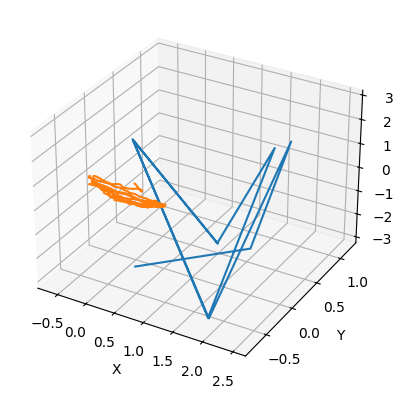

In [44]:
# PLot ground truth and estimated states
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(estimated_states[:,0], estimated_states[:,1], estimated_states[:,2], label='RIEKF')
ax.plot(EULER[:,0], EULER[:,1], EULER[:,2], label='Ground Truth')
ax.set_xlabel('X')
ax.set_ylabel('Y')